In [5]:
%%capture
!pip install sentence-transformers matplotlib

In [6]:
from google.colab import drive

from huggingface_hub import notebook_login

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk. tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from IPython.display import display


In [7]:
# Request access to drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load the dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Comparing Transformer models/gen_ai_jobs_mixedbread_subset_05.csv')

dataset

,job_id,company_name,title,description,location,formatted_work_type,original_listed_time,expiry,job_posting_url,formatted_experience_level,cleaned_description,cleaned_title,combined,similarity_score
0,3784120102,OTB English,Artificial Intelligence Engineer Intern - Chatbot,Company DescriptionOTB English offers business...,United States,Volunteer,2024-04-12 03:56:31,2024-05-12 03:56:31,https://www.linkedin.com/jobs/view/3784120102/...,Not Specified,company descriptionotb english offer business ...,artificial intelligence engineer intern chatbot,artificial intelligence engineer intern chatbo...,0.572612
1,3848960304,Symbolica AI,Senior Machine Learning Research Engineer,Symbolica is building a new foundation for lar...,San Francisco Bay Area,Full-time,2024-04-09 13:33:19,2024-05-09 13:33:19,https://www.linkedin.com/jobs/view/3848960304/...,Not Specified,symbolica building new foundation ai using str...,senior machine learning research engineer,senior machine learning research engineer symb...,0.579077
2,3871631334,NLB Services,Machine Learning Engineer,Job Title: Python AI/ MLType: FulltimeLocation...,"Dallas, TX",Full-time,2024-04-09 13:32:05,2024-05-09 13:32:05,https://www.linkedin.com/jobs/view/3871631334/...,Not Specified,job title python mltype fulltimelocation dalla...,machine learning engineer,machine learning engineer job title python mlt...,0.543281
3,3884432812,Ehub Global Inc,Generative AI Engineer,Role: Generative AI Practice LeaderLocation – ...,"Jersey City, NJ",Contract,2024-04-05 20:20:34,2024-05-05 20:20:34,https://www.linkedin.com/jobs/view/3884432812/...,Mid-Senior level,role generative ai practice leaderlocation jer...,generative ai engineer,generative ai engineer role generative ai prac...,0.595930
4,3884439460,Outlier,AI Training for Nuclear Physics,About the Opportunity: \n\nCutting-Edge Projec...,United States,Full-time,2024-04-05 20:35:48,2024-05-05 20:47:41,https://www.linkedin.com/jobs/view/3884439460/...,Internship,opportunity project work challenging project p...,ai training nuclear physic,ai training nuclear physic opportunity project...,0.551036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,3906226649,Salesforce,Senior Machine Learning Scientist,"To get the best candidate experience, please c...",New York City Metropolitan Area,Full-time,2024-04-19 21:24:15,2024-05-19 21:44:18,https://www.linkedin.com/jobs/view/3906226649/...,Not Specified,get best candidate experience please consider ...,senior machine learning scientist,senior machine learning scientist get best can...,0.523891
383,3906240774,Arcus,"Senior Software Engineer, Machine Learning","DescriptionAt Arcus, our mission is to advance...","New York, NY",Full-time,2024-04-19 22:06:37,2024-10-16 22:06:26,https://www.linkedin.com/jobs/view/3906240774/...,Not Specified,descriptionat arcus mission advance ai better ...,senior software engineer machine learning,senior software engineer machine learning desc...,0.548765
384,3906250437,MRI Software,Machine Learning Engineer I,"From the day we opened our doors in 1971, MRI ...",Greater Cleveland,Full-time,2024-04-19 22:11:50,2024-05-19 22:25:35,https://www.linkedin.com/jobs/view/3906250437/...,Entry level,day opened door 1971 mri software built flexib...,machine learning engineer,machine learning engineer day opened door 1971...,0.547684
385,3906250711,"InterDigital, Inc.","REQ23-842 Intern, AIML Multi-GPU Tensorflow Wi...",About InterDigital\n\nInterDigital develops mo...,"Conshohocken, PA",Internship,2024-04-19 22:24:43,2024-05-19 22:36:27,https://www.linkedin.com/jobs/view/3906250711/...,Internship,interdigital interdigital develops mobile vide...,intern aiml tensorflow wireless model development,intern aiml tensorflow wireless model developm...,0.527656


In [9]:
# Fill missing values in the "description" column with an empty string
dataset["cleaned_description"] = dataset["cleaned_description"].fillna("")

# Ensure all values are strings
dataset["cleaned_description"] = dataset["cleaned_description"].astype(str)

# Combine titles and descriptions into a single column
dataset["combined"] = dataset["cleaned_title"] + " " + dataset["cleaned_description"]

# Convert combined column to a list
titles = dataset["cleaned_title"]
description = dataset["cleaned_description"]
combined = dataset["combined"].astype(str)

# Preview an entry
print(f"Example combined entry: {dataset['combined'].iloc[0]}")

Example combined entry: artificial intelligence engineer intern chatbot company descriptionotb english offer business english class presentation workshop team american language coach aim give student confidence natural language perform crucial business situation provide dynamic learning environment push student achieve greatness english role descriptionthis remote unpaid internship role artificial intelligence engineer specializing chatbot development ai engineer responsible creating implementing model natural language processing nlp system specific focus voice recognition role involves software development working extensively neural network close collaboration team member qualificationsstrong understanding computer science software developmentexperience working neural network develop nlp systemsexperience working voice recognition voice synthesis projectsexpertise pattern recognition machine learning algorithmsrecent computer science related field student current graduate preferred re

In [10]:
# Define categories
categories = {
    "Generative AI and LLM Models": [
        "GPT",
        "LLaMA",
        "Claude",
        "BERT",
        "GAN",
        "VAE"

    ],
    "Techniques": [
        "Retrieval-Augmented Generation (RAG)",
        "Retrieval-Augmented Thoughts (RAT)",
        "Chain-of-Thought (CoT)",
        "Fine-tuning",
        "Hallucination mitigation",
        "Data augmentation"
    ],
    "Tools and Frameworks": [
        "LangChain",
        "Amazon Bedrock",
        "Azure OpenAI Studio",
        "LlamaIndex",
        "HuggingFace"
    ],
    "Application Areas": [
        "Chatbots",
        "NLP-based voice recognition",
        "Developer tools for AI-assisted coding",
        "Enterprise solutions"
    ],
    "Cloud and Infrastructure": [
        "AWS",
        "Azure",
        "Google Cloud",
        "Docker",
        "Jenkins",
        "Kubernetes"
    ],
    "Data Engineering and Storage": [
        "Large-scale data pipelines",
        "Vector databases",
        "Indexing systems"
    ],
    "Governance and Ethics": [
        "LLM governance",
        "Hallucination mitigation",
        "Bias-free outputs",
        "AI ethics"
    ],
    "Education": [
        "Computer Science",
        "Artificial Intelligence",
        "Information Science"
    ]
}

In [11]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
# Preprocessing function for text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Tokenize while preserving multi-word terms and important meaning
    tokens = word_tokenize(text.lower())

    # If a token contains only alphanumeric characters or hyphens, lemmatize and retain it
    processed_tokens = [
        lemmatizer.lemmatize(word) if '-' not in word else word.replace('-', ' ')
        for word in tokens if word.isalnum() or '-' in word
    ]

    # Remove stop words but keep important compound terms intact
    processed_tokens = [token for token in processed_tokens if token not in stop_words]

    return ' '.join(processed_tokens)

# Apply preprocessing to all categories
preprocessed_categories = {
    category: [preprocess_text(item) for item in items]
    for category, items in categories.items()
}

# Print preprocessed results
for category, items in preprocessed_categories.items():
    print(f"Category: {category}")
    for original, preprocessed in zip(categories[category], items):
        print(f"  Original: {original}")
        print(f"  Preprocessed: {preprocessed}")
    print()


Category: Generative AI and LLM Models
  Original: GPT
  Preprocessed: gpt
  Original: LLaMA
  Preprocessed: llama
  Original: Claude
  Preprocessed: claude
  Original: BERT
  Preprocessed: bert
  Original: GAN
  Preprocessed: gan
  Original: VAE
  Preprocessed: vae

Category: Techniques
  Original: Retrieval-Augmented Generation (RAG)
  Preprocessed: retrieval augmented generation rag
  Original: Retrieval-Augmented Thoughts (RAT)
  Preprocessed: retrieval augmented thought rat
  Original: Chain-of-Thought (CoT)
  Preprocessed: chain of thought cot
  Original: Fine-tuning
  Preprocessed: fine tuning
  Original: Hallucination mitigation
  Preprocessed: hallucination mitigation
  Original: Data augmentation
  Preprocessed: data augmentation

Category: Tools and Frameworks
  Original: LangChain
  Preprocessed: langchain
  Original: Amazon Bedrock
  Preprocessed: amazon bedrock
  Original: Azure OpenAI Studio
  Preprocessed: azure openai studio
  Original: LlamaIndex
  Preprocessed: llama

In [ ]:
notebook_login()

In [14]:
# embedding model
models = {"MixedBread": SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")}

# Pre-calculate embeddings for job postings
job_postings_embeddings = {
    model_name: model.encode(combined, convert_to_numpy=True, show_progress_bar=True)
    for model_name, model in models.items()
}

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

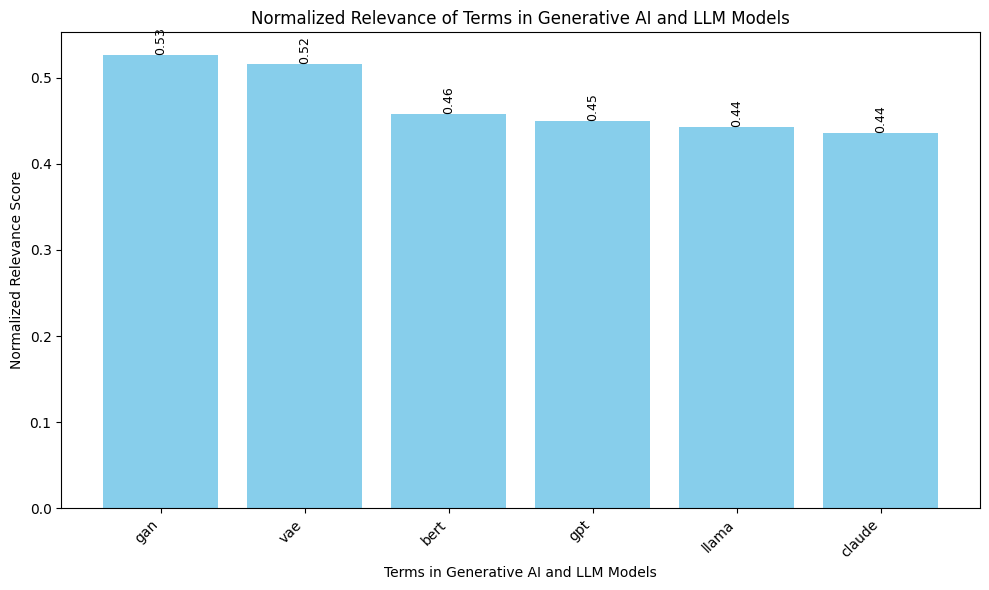

In [15]:
# Generate embeddings for the "Generative AI and LLM Models" category
gen_ai_llm_embeddings = {
    item: models["MixedBread"].encode(item, convert_to_numpy=True)
    for item in preprocessed_categories["Generative AI and LLM Models"]
}

# Compute similarity scores for each item in the "Generative AI and LLM Models" category
gen_ai_llm_scores = {
    item: cosine_similarity(job_postings_embeddings["MixedBread"], [embedding]).mean()
    for item, embedding in gen_ai_llm_embeddings.items()
}

# Normalize scores for the "Generative AI and LLM Models" category
def normalize_scores(scores, min_value=0.1, max_value=1.0):
    min_score = min(scores.values())
    max_score = max(scores.values())
    return {key: min_value + (value - min_score) * (max_value - min_value) / (max_score - min_score)
            for key, value in scores.items()}

normalized_gen_ai_llm_scores = normalize_scores(gen_ai_llm_scores)

# Sort normalized scores for plotting
sorted_gen_ai_llm_scores = dict(sorted(gen_ai_llm_scores.items(), key=lambda x: x[1], reverse=True))

# Plot the scores for the "Generative AI and LLM Models" category
plt.figure(figsize=(10, 6))
plt.bar(sorted_gen_ai_llm_scores.keys(), sorted_gen_ai_llm_scores.values(), color='skyblue')
plt.xlabel("Terms in Generative AI and LLM Models")
plt.ylabel("Normalized Relevance Score")
plt.title("Normalized Relevance of Terms in Generative AI and LLM Models")
plt.xticks(rotation=45, ha="right")

# Annotate bars with normalized scores
for i, (key, value) in enumerate(sorted_gen_ai_llm_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()


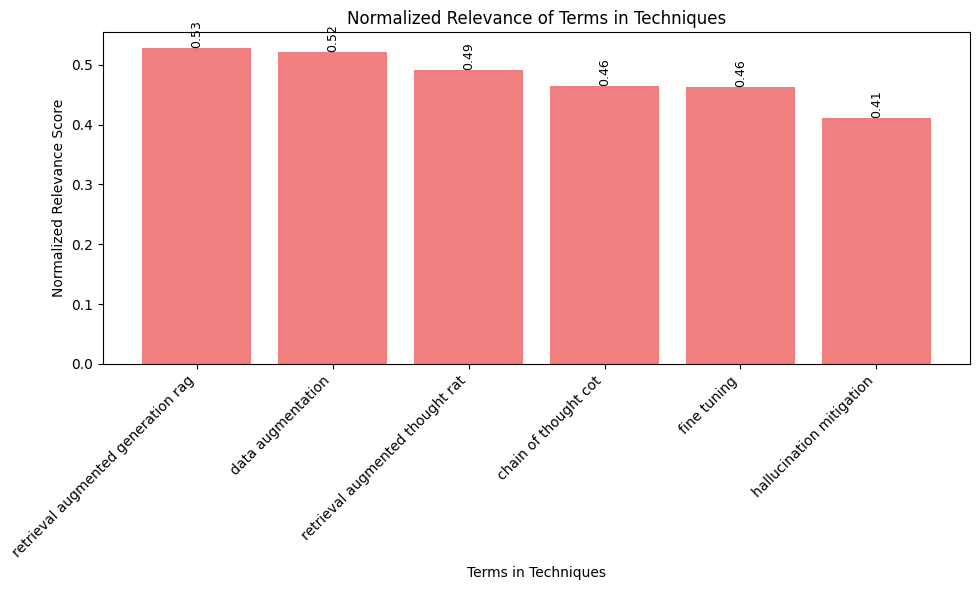

In [16]:
# Generate embeddings for the "Techniques" category
techniques_embeddings = {
    item: models["MixedBread"].encode(item, convert_to_numpy=True)
    for item in preprocessed_categories["Techniques"]
}

# Compute similarity scores for each item in the "Techniques" category
techniques_scores = {
    item: cosine_similarity(job_postings_embeddings["MixedBread"], [embedding]).mean()
    for item, embedding in techniques_embeddings.items()
}

# Normalize scores for the "Techniques" category
def normalize_scores(scores, min_value=0.1, max_value=1.0):
    min_score = min(scores.values())
    max_score = max(scores.values())
    return {key: min_value + (value - min_score) * (max_value - min_value) / (max_score - min_score)
            for key, value in scores.items()}

normalized_techniques_scores = normalize_scores(techniques_scores)

# Sort normalized scores for plotting
sorted_techniques_scores = dict(sorted(techniques_scores.items(), key=lambda x: x[1], reverse=True))

# Plot the scores for the "Techniques" category
plt.figure(figsize=(10, 6))
plt.bar(sorted_techniques_scores.keys(), sorted_techniques_scores.values(), color='lightcoral')
plt.xlabel("Terms in Techniques")
plt.ylabel("Normalized Relevance Score")
plt.title("Normalized Relevance of Terms in Techniques")
plt.xticks(rotation=45, ha="right")

# Annotate bars with normalized scores
for i, (key, value) in enumerate(sorted_techniques_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()


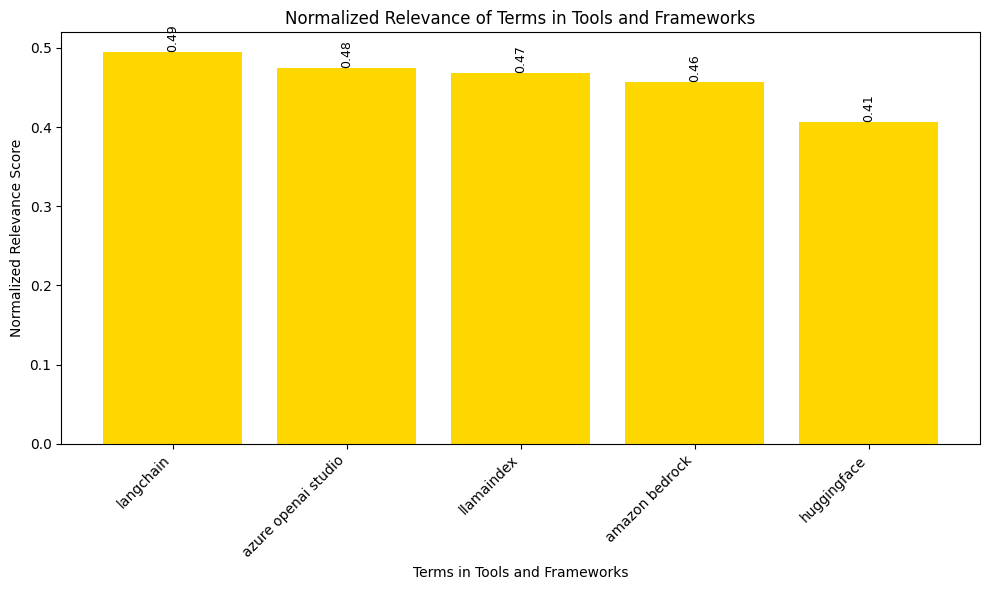

In [17]:
# Generate embeddings for the "Tools and Frameworks" category
tools_frameworks_embeddings = {
    item: models["MixedBread"].encode(item, convert_to_numpy=True)
    for item in preprocessed_categories["Tools and Frameworks"]
}

# Compute similarity scores for each item in the "Tools and Frameworks" category
tools_frameworks_scores = {
    item: cosine_similarity(job_postings_embeddings["MixedBread"], [embedding]).mean()
    for item, embedding in tools_frameworks_embeddings.items()
}

# Normalize scores for the "Tools and Frameworks" category
normalized_tools_frameworks_scores = normalize_scores(tools_frameworks_scores)

# Sort normalized scores for plotting
sorted_tools_frameworks_scores = dict(sorted(tools_frameworks_scores.items(), key=lambda x: x[1], reverse=True))

# Plot the scores for the "Tools and Frameworks" category
plt.figure(figsize=(10, 6))
plt.bar(sorted_tools_frameworks_scores.keys(), sorted_tools_frameworks_scores.values(), color='gold')
plt.xlabel("Terms in Tools and Frameworks")
plt.ylabel("Normalized Relevance Score")
plt.title("Normalized Relevance of Terms in Tools and Frameworks")
plt.xticks(rotation=45, ha="right")

# Annotate bars with normalized scores
for i, (key, value) in enumerate(sorted_tools_frameworks_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()


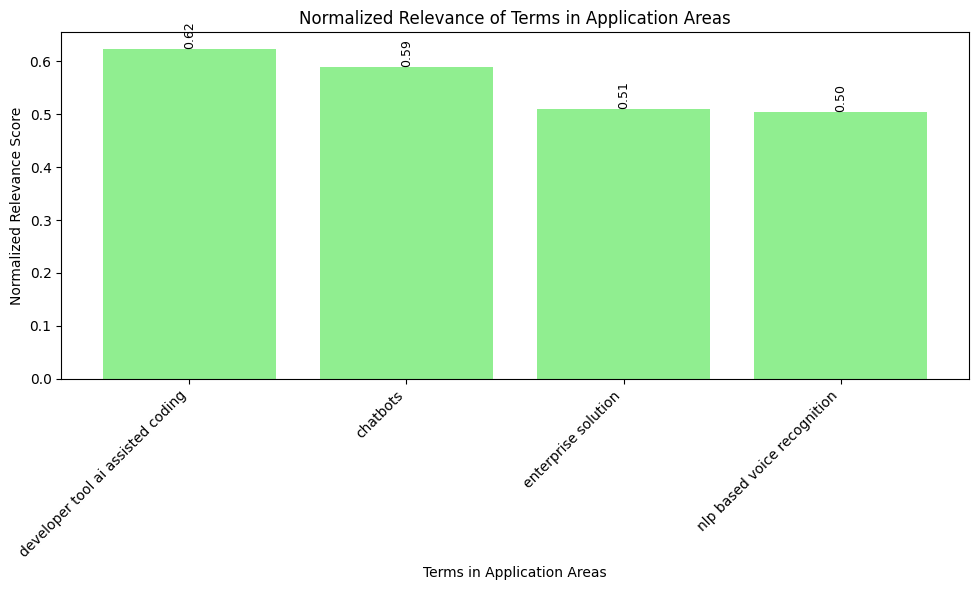

In [18]:
# Generate embeddings for the "Application Areas" category
application_areas_embeddings = {
    item: models["MixedBread"].encode(item, convert_to_numpy=True)
    for item in preprocessed_categories["Application Areas"]
}

# Compute similarity scores for each item in the "Application Areas" category
application_areas_scores = {
    item: cosine_similarity(job_postings_embeddings["MixedBread"], [embedding]).mean()
    for item, embedding in application_areas_embeddings.items()
}

# Normalize scores for the "Application Areas" category
normalized_application_areas_scores = normalize_scores(application_areas_scores)

# Sort normalized scores for plotting
sorted_application_areas_scores = dict(sorted(application_areas_scores.items(), key=lambda x: x[1], reverse=True))

# Plot the scores for the "Application Areas" category
plt.figure(figsize=(10, 6))
plt.bar(sorted_application_areas_scores.keys(), sorted_application_areas_scores.values(), color='lightgreen')
plt.xlabel("Terms in Application Areas")
plt.ylabel("Normalized Relevance Score")
plt.title("Normalized Relevance of Terms in Application Areas")
plt.xticks(rotation=45, ha="right")

# Annotate bars with normalized scores
for i, (key, value) in enumerate(sorted_application_areas_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()


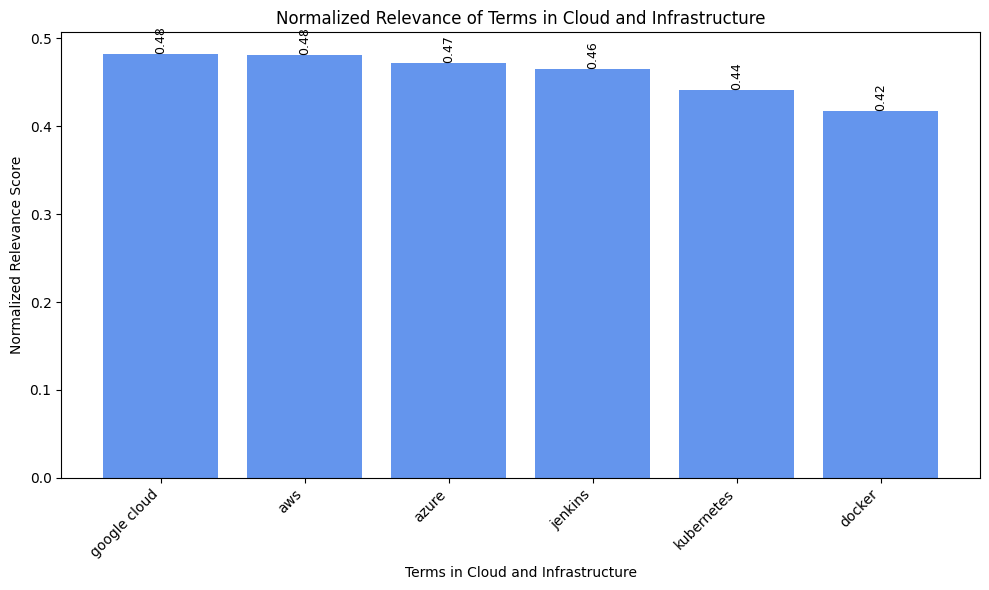

In [19]:
# Generate embeddings for the "Cloud and Infrastructure" category
cloud_infrastructure_embeddings = {
    item: models["MixedBread"].encode(item, convert_to_numpy=True)
    for item in preprocessed_categories["Cloud and Infrastructure"]
}

# Compute similarity scores for each item in the "Cloud and Infrastructure" category
cloud_infrastructure_scores = {
    item: cosine_similarity(job_postings_embeddings["MixedBread"], [embedding]).mean()
    for item, embedding in cloud_infrastructure_embeddings.items()
}

# Normalize scores for the "Cloud and Infrastructure" category
normalized_cloud_infrastructure_scores = normalize_scores(cloud_infrastructure_scores)

# Sort normalized scores for plotting
sorted_cloud_infrastructure_scores = dict(sorted(cloud_infrastructure_scores.items(), key=lambda x: x[1], reverse=True))

# Plot the scores for the "Cloud and Infrastructure" category
plt.figure(figsize=(10, 6))
plt.bar(sorted_cloud_infrastructure_scores.keys(), sorted_cloud_infrastructure_scores.values(), color='cornflowerblue')
plt.xlabel("Terms in Cloud and Infrastructure")
plt.ylabel("Normalized Relevance Score")
plt.title("Normalized Relevance of Terms in Cloud and Infrastructure")
plt.xticks(rotation=45, ha="right")

# Annotate bars with normalized scores
for i, (key, value) in enumerate(sorted_cloud_infrastructure_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()


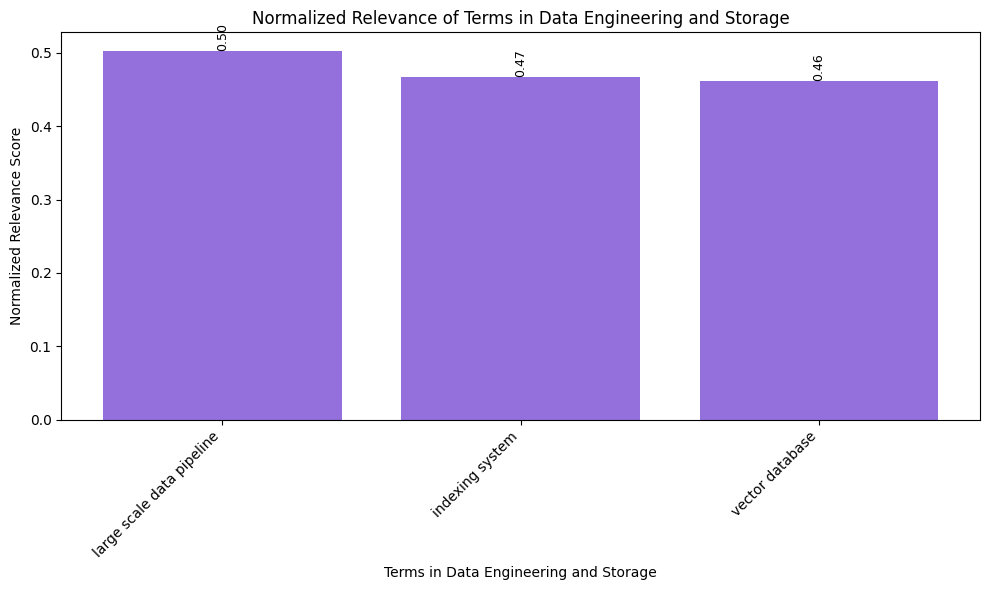

In [20]:
# Generate embeddings for the "Data Engineering and Storage" category
data_engineering_storage_embeddings = {
    item: models["MixedBread"].encode(item, convert_to_numpy=True)
    for item in preprocessed_categories["Data Engineering and Storage"]
}

# Compute similarity scores for each item in the "Data Engineering and Storage" category
data_engineering_storage_scores = {
    item: cosine_similarity(job_postings_embeddings["MixedBread"], [embedding]).mean()
    for item, embedding in data_engineering_storage_embeddings.items()
}

# Normalize scores for the "Data Engineering and Storage" category
normalized_data_engineering_storage_scores = normalize_scores(data_engineering_storage_scores)

# Sort normalized scores for plotting
sorted_data_engineering_storage_scores = dict(sorted(data_engineering_storage_scores.items(), key=lambda x: x[1], reverse=True))

# Plot the scores for the "Data Engineering and Storage" category
plt.figure(figsize=(10, 6))
plt.bar(sorted_data_engineering_storage_scores.keys(), sorted_data_engineering_storage_scores.values(), color='mediumpurple')
plt.xlabel("Terms in Data Engineering and Storage")
plt.ylabel("Normalized Relevance Score")
plt.title("Normalized Relevance of Terms in Data Engineering and Storage")
plt.xticks(rotation=45, ha="right")

# Annotate bars with normalized scores
for i, (key, value) in enumerate(sorted_data_engineering_storage_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()


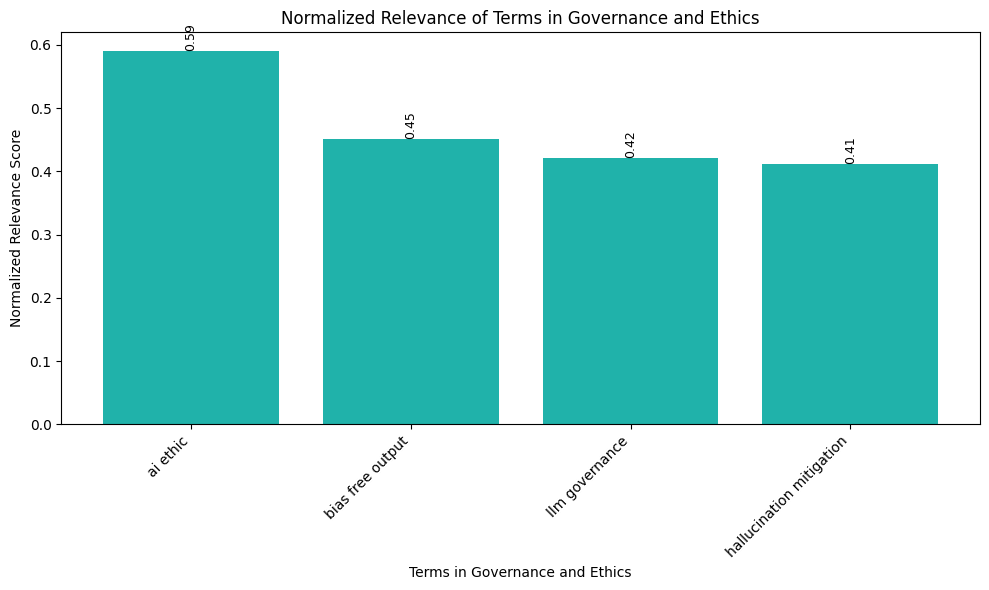

In [21]:
# Generate embeddings for the "Governance and Ethics" category
governance_ethics_embeddings = {
    item: models["MixedBread"].encode(item, convert_to_numpy=True)
    for item in preprocessed_categories["Governance and Ethics"]
}

# Compute similarity scores for each item in the "Governance and Ethics" category
governance_ethics_scores = {
    item: cosine_similarity(job_postings_embeddings["MixedBread"], [embedding]).mean()
    for item, embedding in governance_ethics_embeddings.items()
}

# Normalize scores for the "Governance and Ethics" category
normalized_governance_ethics_scores = normalize_scores(governance_ethics_scores)

# Sort normalized scores for plotting
sorted_governance_ethics_scores = dict(sorted(governance_ethics_scores.items(), key=lambda x: x[1], reverse=True))

# Plot the scores for the "Governance and Ethics" category
plt.figure(figsize=(10, 6))
plt.bar(sorted_governance_ethics_scores.keys(), sorted_governance_ethics_scores.values(), color='lightseagreen')
plt.xlabel("Terms in Governance and Ethics")
plt.ylabel("Normalized Relevance Score")
plt.title("Normalized Relevance of Terms in Governance and Ethics")
plt.xticks(rotation=45, ha="right")

# Annotate bars with normalized scores
for i, (key, value) in enumerate(sorted_governance_ethics_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()


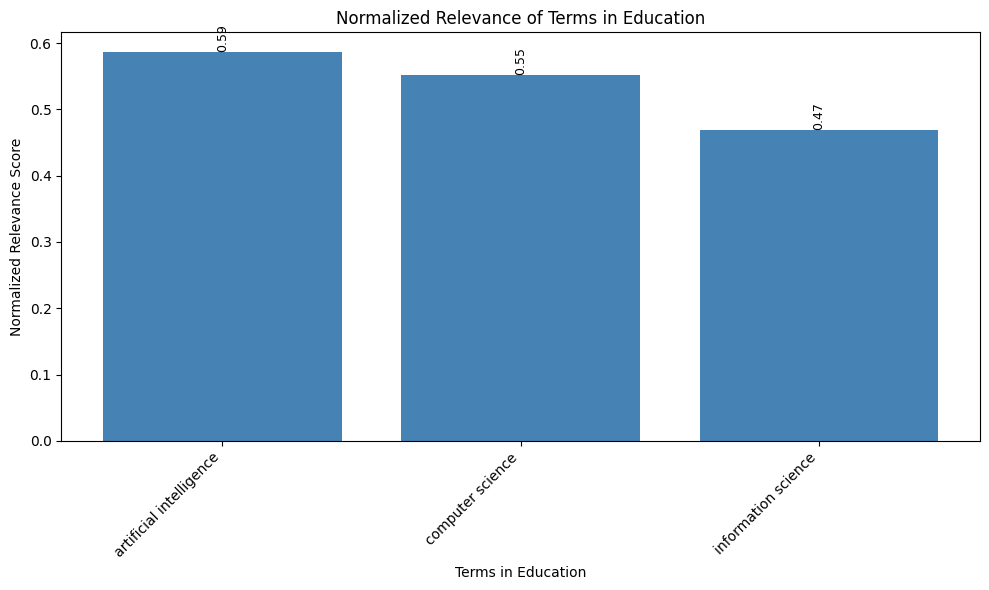

In [22]:
# Generate embeddings for the "Education" category
education_embeddings = {
    item: models["MixedBread"].encode(item, convert_to_numpy=True)
    for item in preprocessed_categories["Education"]
}

# Compute similarity scores for each item in the "Education" category
education_scores = {
    item: cosine_similarity(job_postings_embeddings["MixedBread"], [embedding]).mean()
    for item, embedding in education_embeddings.items()
}

# Normalize scores for the "Education" category
normalized_education_scores = normalize_scores(education_scores)

# Sort normalized scores for plotting
sorted_education_scores = dict(sorted(education_scores.items(), key=lambda x: x[1], reverse=True))

# Plot the scores for the "Education" category
plt.figure(figsize=(10, 6))
plt.bar(sorted_education_scores.keys(), sorted_education_scores.values(), color='steelblue')
plt.xlabel("Terms in Education")
plt.ylabel("Normalized Relevance Score")
plt.title("Normalized Relevance of Terms in Education")
plt.xticks(rotation=45, ha="right")

# Annotate bars with normalized scores
for i, (key, value) in enumerate(sorted_education_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()


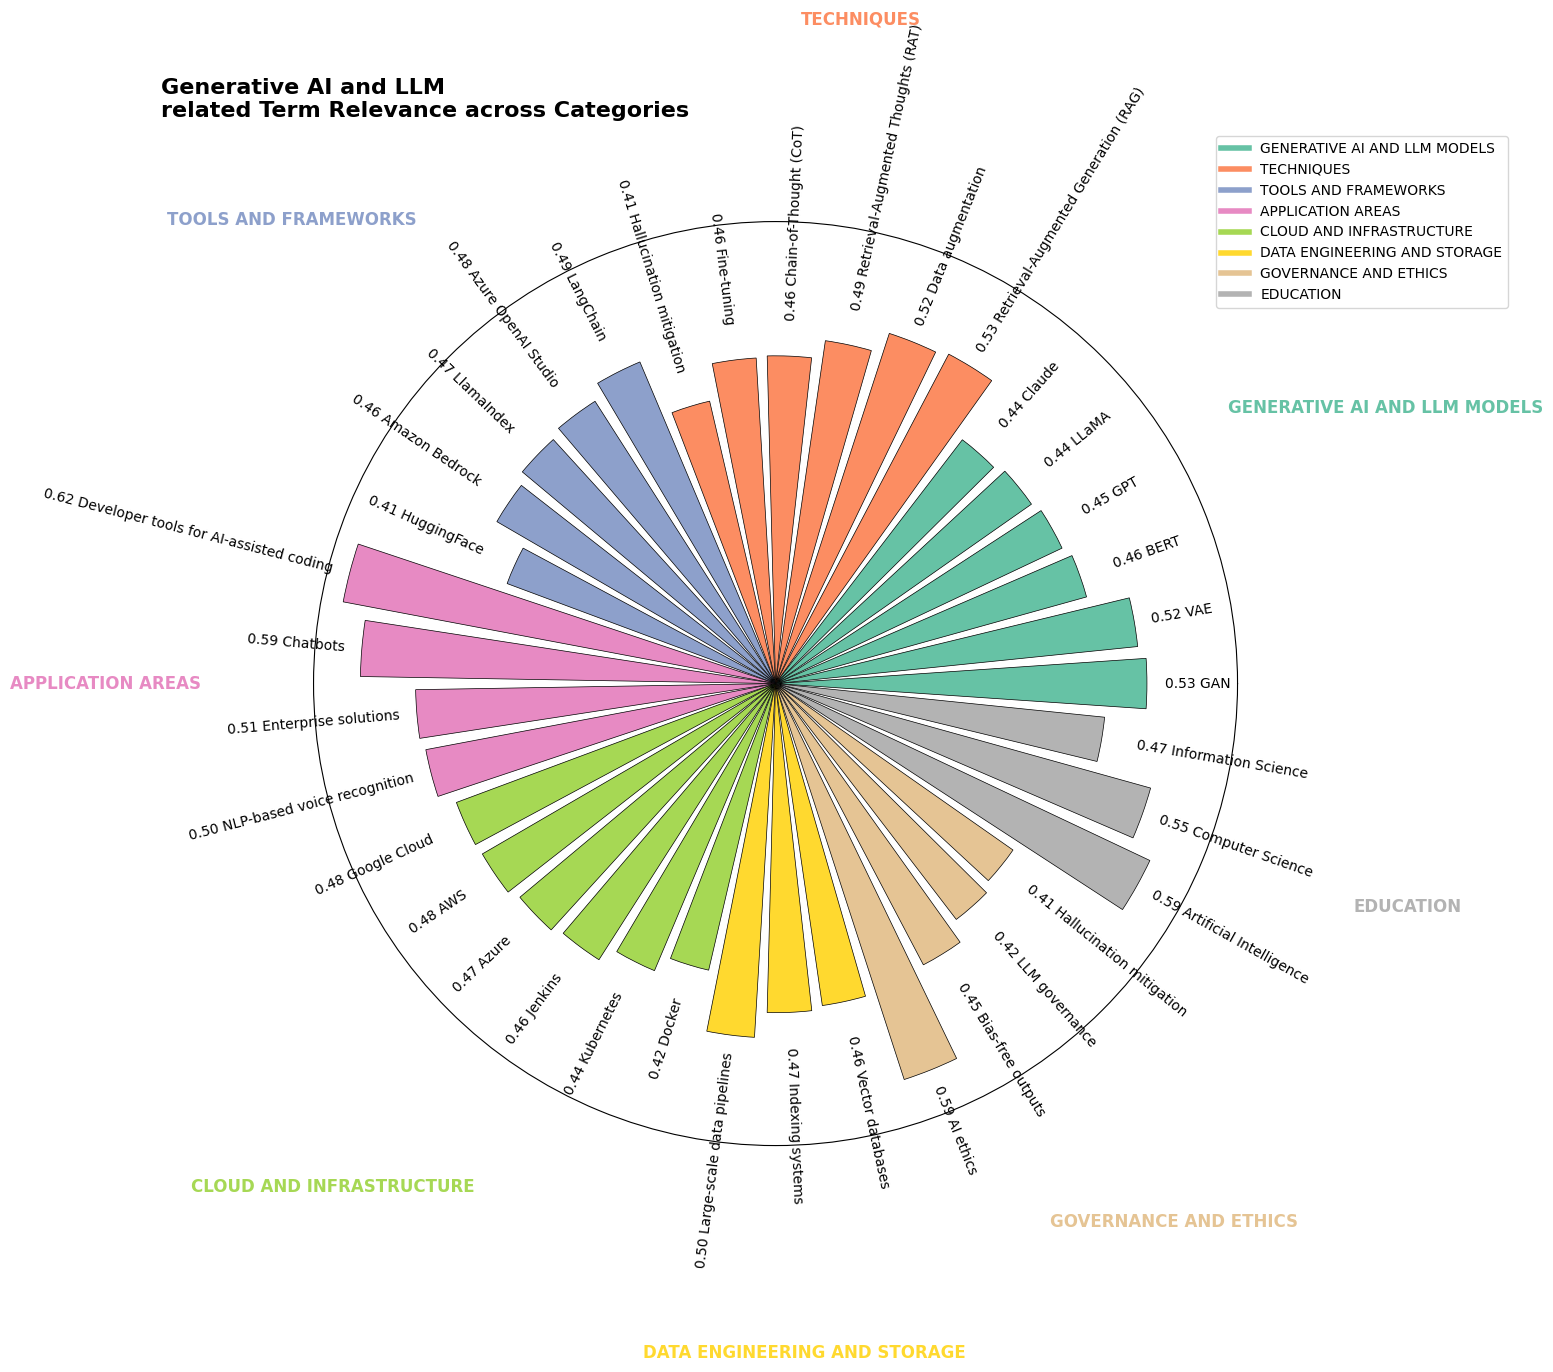

In [23]:
# Use the mapping of original to preprocessed terms
term_mapping = {
    "Generative AI and LLM Models": {
        "GPT": "gpt",
        "LLaMA": "llama",
        "Claude": "claude",
        "BERT": "bert",
        "GAN": "gan",
        "VAE": "vae"
    },
    "Techniques": {
        "Retrieval-Augmented Generation (RAG)": "retrieval augmented generation rag",
        "Retrieval-Augmented Thoughts (RAT)": "retrieval augmented thought rat",
        "Chain-of-Thought (CoT)": "chain of thought cot",
        "Fine-tuning": "fine tuning",
        "Hallucination mitigation": "hallucination mitigation",
        "Data augmentation": "data augmentation"
    },
    "Tools and Frameworks": {
        "LangChain": "langchain",
        "Amazon Bedrock": "amazon bedrock",
        "Azure OpenAI Studio": "azure openai studio",
        "LlamaIndex": "llamaindex",
        "HuggingFace": "huggingface"
    },
    "Application Areas": {
        "Chatbots": "chatbots",
        "NLP-based voice recognition": "nlp based voice recognition",
        "Developer tools for AI-assisted coding": "developer tool ai assisted coding",
        "Enterprise solutions": "enterprise solution"
    },
    "Cloud and Infrastructure": {
        "AWS": "aws",
        "Azure": "azure",
        "Google Cloud": "google cloud",
        "Docker": "docker",
        "Jenkins": "jenkins",
        "Kubernetes": "kubernetes"
    },
    "Data Engineering and Storage": {
        "Large-scale data pipelines": "large scale data pipeline",
        "Vector databases": "vector database",
        "Indexing systems": "indexing system"
    },
    "Governance and Ethics": {
        "LLM governance": "llm governance",
        "Hallucination mitigation": "hallucination mitigation",
        "Bias-free outputs": "bias free output",
        "AI ethics": "ai ethic"
    },
    "Education": {
        "Computer Science": "computer science",
        "Artificial Intelligence": "artificial intelligence",
        "Information Science": "information science"
    }
}

# Compute category scores (Define category_scores if not already provided)
category_scores = {
    category: {
        term: cosine_similarity(job_postings_embeddings["MixedBread"], [models["MixedBread"].encode(term_mapping[category][term], convert_to_numpy=True)]).mean()
        for term in term_mapping[category]
    }
    for category in term_mapping
}

# Use the mapping of original to preprocessed terms
categories = list(term_mapping.keys())
preprocessed_terms = [term_mapping[category][term] for category in categories for term in term_mapping[category]]
categories_repeated = [category for category in categories for _ in term_mapping[category]]

# Flatten scores and include in term names
terms_with_scores = []
scores = []
for category in categories:
    for term, score in category_scores[category].items():
        terms_with_scores.append(f"{score:.2f} {term}")
        scores.append(score)

# Normalize scores for each category separately
def normalize_category_scores(category_scores, min_value=0.1, max_value=1.0):
    normalized_category_scores = {}
    for category, scores in category_scores.items():
        min_score = min(scores.values())
        max_score = max(scores.values())
        if max_score == min_score:  # Handle edge case where all scores are the same
            normalized_scores = {term: min_value for term in scores}
        else:
            normalized_scores = {
                term: min_value + (score - min_score) * (max_value - min_value) / (max_score - min_score)
                for term, score in scores.items()
            }
        normalized_category_scores[category] = normalized_scores
    return normalized_category_scores

# Normalize the scores for all categories
# normalized_category_scores = normalize_category_scores(category_scores)
normalized_category_scores = category_scores


# Flatten the normalized scores and include them in term labels (sorted by score per category)
terms_with_scores = []
scores = []
categories_repeated = []
for category, terms in normalized_category_scores.items():
    # Sort terms by their normalized scores within each category
    sorted_terms = sorted(terms.items(), key=lambda x: x[1], reverse=True)
    for term, score in sorted_terms:
        terms_with_scores.append(f"{score:.2f} {term}")
        scores.append(score)
        categories_repeated.append(category)

# Compute angles for the circular barplot
N = len(terms_with_scores)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()




# Map unique colors to categories
category_colors = {
    category: plt.cm.Set2(i / len(term_mapping)) for i, category in enumerate(term_mapping)
}
bar_colors = [category_colors[cat] for cat in categories_repeated]

# Adjust Plot Size and Aspect
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, polar=True)

# Plot bars with scores
for i, (angle, score, color) in enumerate(zip(angles, scores, bar_colors)):
    ax.bar(angle, score, width=2 * np.pi / N * 0.8, color=color, edgecolor='black', linewidth=0.5)

# Adjust term label placement and readability
for i, (angle, term) in enumerate(zip(angles, terms_with_scores)):
    rotation = np.degrees(angle)
    alignment = 'right' if 90 <= rotation <= 270 else 'left'
    rotation = rotation + 180 if 90 <= rotation <= 270 else rotation

    # Push low-score labels outward
    radial_distance = scores[i] + 0.05 if scores[i] <= 0.5 else scores[i] + 0.025
    ax.text(
        angle, radial_distance, term,
        ha=alignment, va='center', fontsize=10, rotation=rotation, rotation_mode='anchor'
    )

# Adjust category label positioning
category_starts = np.cumsum([0] + [len(term_mapping[cat]) for cat in list(term_mapping.keys())[:-1]])
for i, category in enumerate(list(term_mapping.keys())):
    start_angle = angles[category_starts[i]]
    end_angle = angles[category_starts[i + 1] - 1] if i < len(term_mapping) - 1 else angles[-1]
    category_angle = (start_angle + end_angle) / 2
    ax.text(
        category_angle, 0.95, category.upper(),  # Push category labels outward
        fontsize=12, ha='center', va='center', color=category_colors[category], fontweight='bold'
    )

# Customize grid and tick visibility
ax.grid(False)
ax.set_yticks([])
ax.set_xticks([])

# Add legend on the side
legend_patches = [
    plt.Line2D([0], [0], color=color, lw=4, label=category.upper())
    for category, color in category_colors.items()
]
ax.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

# Add title in the top-left corner of the figure
plt.gcf().text(
    0, 1,  # x, y in figure coordinates (adjust as needed)
    "Generative AI and LLM\nrelated Term Relevance across Categories",
    fontsize=16, fontweight="bold", ha='left', va='top'
)
# Display the plot
plt.show()




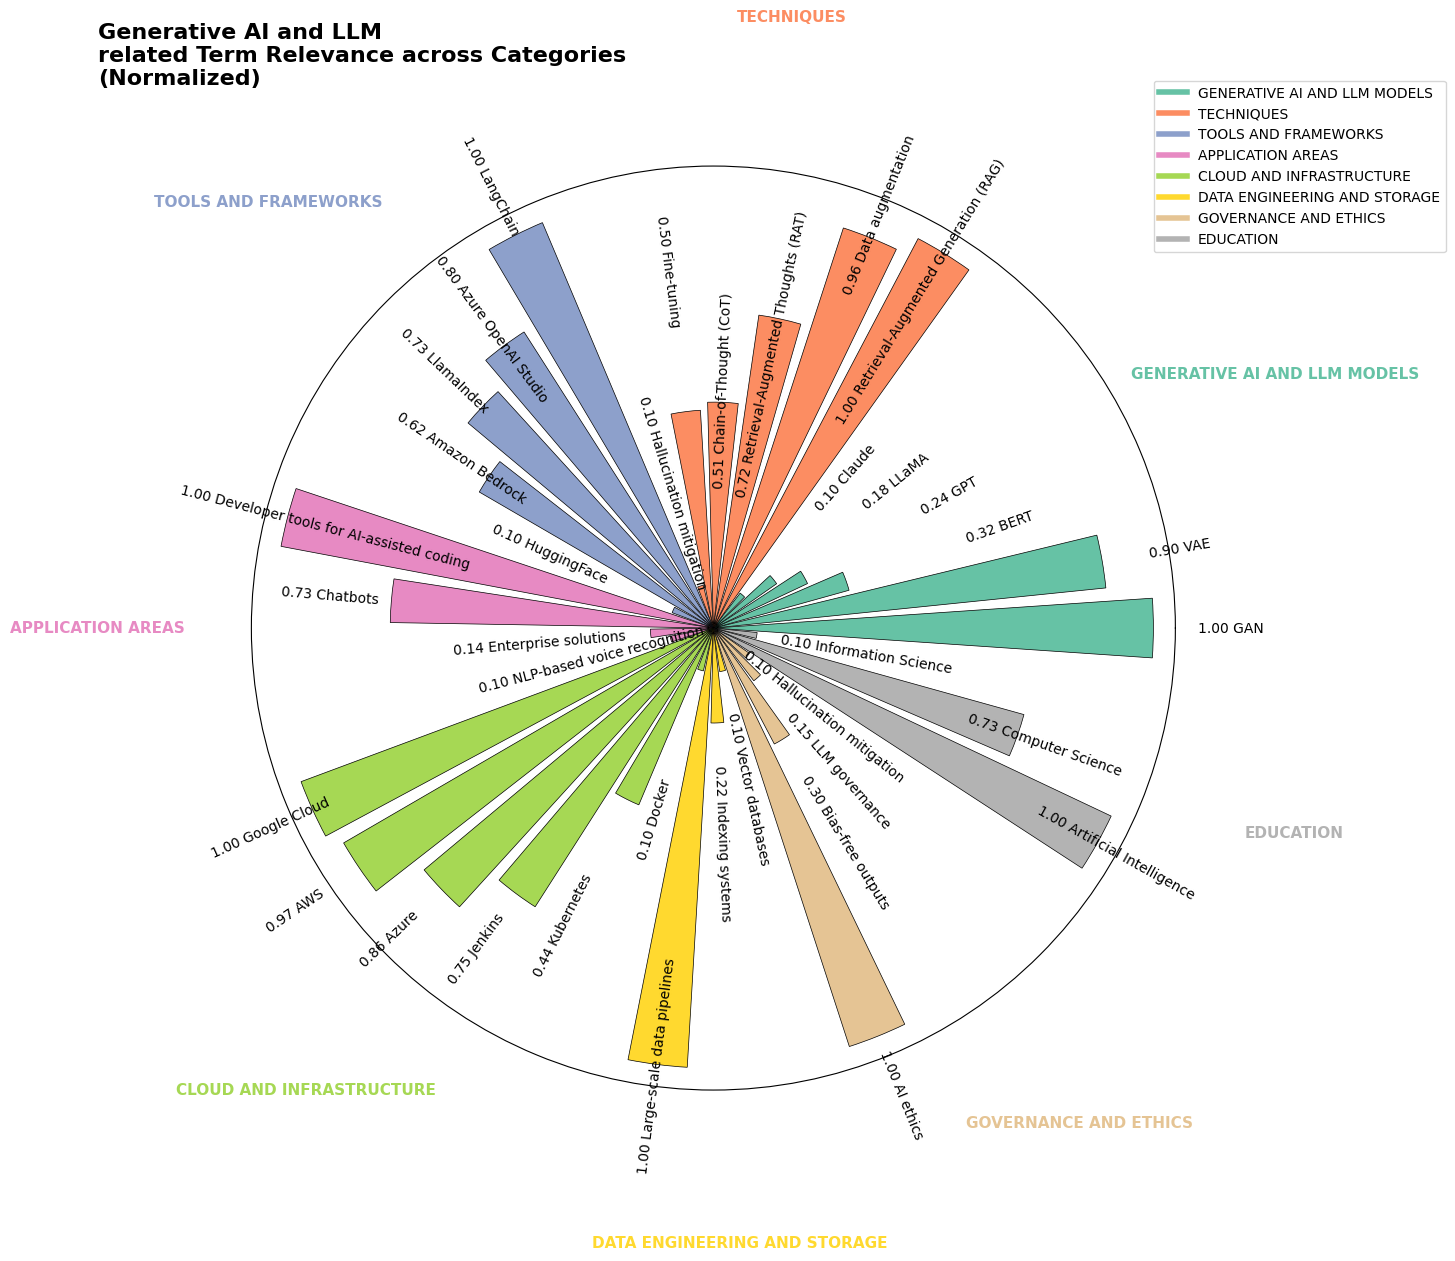

In [24]:
# Use the mapping of original to preprocessed terms
term_mapping = {
    "Generative AI and LLM Models": {
        "GPT": "gpt",
        "LLaMA": "llama",
        "Claude": "claude",
        "BERT": "bert",
        "GAN": "gan",
        "VAE": "vae"
    },
    "Techniques": {
        "Retrieval-Augmented Generation (RAG)": "retrieval augmented generation rag",
        "Retrieval-Augmented Thoughts (RAT)": "retrieval augmented thought rat",
        "Chain-of-Thought (CoT)": "chain of thought cot",
        "Fine-tuning": "fine tuning",
        "Hallucination mitigation": "hallucination mitigation",
        "Data augmentation": "data augmentation"
    },
    "Tools and Frameworks": {
        "LangChain": "langchain",
        "Amazon Bedrock": "amazon bedrock",
        "Azure OpenAI Studio": "azure openai studio",
        "LlamaIndex": "llamaindex",
        "HuggingFace": "huggingface"
    },
    "Application Areas": {
        "Chatbots": "chatbots",
        "NLP-based voice recognition": "nlp based voice recognition",
        "Developer tools for AI-assisted coding": "developer tool ai assisted coding",
        "Enterprise solutions": "enterprise solution"
    },
    "Cloud and Infrastructure": {
        "AWS": "aws",
        "Azure": "azure",
        "Google Cloud": "google cloud",
        "Docker": "docker",
        "Jenkins": "jenkins",
        "Kubernetes": "kubernetes"
    },
    "Data Engineering and Storage": {
        "Large-scale data pipelines": "large scale data pipeline",
        "Vector databases": "vector database",
        "Indexing systems": "indexing system"
    },
    "Governance and Ethics": {
        "LLM governance": "llm governance",
        "Hallucination mitigation": "hallucination mitigation",
        "Bias-free outputs": "bias free output",
        "AI ethics": "ai ethic"
    },
    "Education": {
        "Computer Science": "computer science",
        "Artificial Intelligence": "artificial intelligence",
        "Information Science": "information science"
    }
}

# Compute category scores (Define category_scores if not already provided)
category_scores = {
    category: {
        term: cosine_similarity(job_postings_embeddings["MixedBread"], [models["MixedBread"].encode(term_mapping[category][term], convert_to_numpy=True)]).mean()
        for term in term_mapping[category]
    }
    for category in term_mapping
}

# Use the mapping of original to preprocessed terms
categories = list(term_mapping.keys())
preprocessed_terms = [term_mapping[category][term] for category in categories for term in term_mapping[category]]
categories_repeated = [category for category in categories for _ in term_mapping[category]]

# Flatten scores and include in term names
terms_with_scores = []
scores = []
for category in categories:
    for term, score in category_scores[category].items():
        terms_with_scores.append(f"{score:.2f} {term}")
        scores.append(score)

# Normalize scores for each category separately
def normalize_category_scores(category_scores, min_value=0.1, max_value=1.0):
    normalized_category_scores = {}
    for category, scores in category_scores.items():
        min_score = min(scores.values())
        max_score = max(scores.values())
        if max_score == min_score:  # Handle edge case where all scores are the same
            normalized_scores = {term: min_value for term in scores}
        else:
            normalized_scores = {
                term: min_value + (score - min_score) * (max_value - min_value) / (max_score - min_score)
                for term, score in scores.items()
            }
        normalized_category_scores[category] = normalized_scores
    return normalized_category_scores

# Normalize the scores for all categories
normalized_category_scores = normalize_category_scores(category_scores)

# Flatten the normalized scores and include them in term labels (sorted by score per category)
terms_with_scores = []
scores = []
categories_repeated = []
for category, terms in normalized_category_scores.items():
    # Sort terms by their normalized scores within each category
    sorted_terms = sorted(terms.items(), key=lambda x: x[1], reverse=True)
    for term, score in sorted_terms:
        terms_with_scores.append(f"{score:.2f} {term}")
        scores.append(score)
        categories_repeated.append(category)

# Compute angles for the circular barplot
N = len(terms_with_scores)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()


# Map unique colors to categories
category_colors = {
    category: plt.cm.Set2(i / len(term_mapping)) for i, category in enumerate(term_mapping)
}
bar_colors = [category_colors[cat] for cat in categories_repeated]

# Plot circular barplot
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, polar=True)

# Plot bars with scores
for i, (angle, score, color) in enumerate(zip(angles, scores, bar_colors)):
    ax.bar(angle, score, width=2 * np.pi / N * 0.8, color=color, edgecolor='black', linewidth=0.5)

# Add term labels with scores at the start
for i, (angle, term) in enumerate(zip(angles, terms_with_scores)):
    rotation = np.degrees(angle)
    alignment = 'left' if 90 <= rotation <= 270 else 'right'
    rotation = rotation + 180 if 90 <= rotation <= 270 else rotation

    # Adjust label placement to push low-score terms outward slightly
    radial_distance = scores[i] + 0.45 if scores[i] <= 0.5 else scores[i] + 0.25
    ax.text(
        angle, radial_distance, term,
        ha=alignment, va='center', fontsize=10, rotation=rotation, rotation_mode='anchor'
    )

# Correct the way category labels are computed
category_starts = np.cumsum([0] + [len(term_mapping[cat]) for cat in list(term_mapping.keys())[:-1]])

for i, category in enumerate(list(term_mapping.keys())):
    start_angle = angles[category_starts[i]]
    end_angle = angles[category_starts[i + 1] - 1] if i < len(term_mapping) - 1 else angles[-1]
    category_angle = (start_angle + end_angle) / 2
    ax.text(
        category_angle, 1.4, category.upper(),
        fontsize=11, ha='center', va='center', color=category_colors[category], fontweight='bold'
    )

# Remove gridlines and ticks
ax.grid(False)
ax.set_yticks([])
ax.set_xticks([])

# Add legend
legend_patches = [
    plt.Line2D([0], [0], color=color, lw=4, label=category.upper())
    for category, color in category_colors.items()
]
ax.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

# Add title in the top-left corner of the figure
plt.gcf().text(
    0, 1,  # x, y in figure coordinates (adjust as needed)
    "Generative AI and LLM\nrelated Term Relevance across Categories\n(Normalized)",
    fontsize=16, fontweight="bold", ha='left', va='top'
)

# Display the plot
plt.show()



In [ ]:
import pandas as pd

# Create a compact table for the provided information
data = {
    "Category": [
        "Generative AI and LLM Models", "Generative AI and LLM Models", "Generative AI and LLM Models",
        "Generative AI and LLM Models", "Generative AI and LLM Models", "Generative AI and LLM Models",
        "Techniques", "Techniques", "Techniques", "Techniques", "Techniques", "Techniques",
        "Tools and Frameworks", "Tools and Frameworks", "Tools and Frameworks", "Tools and Frameworks", "Tools and Frameworks",
        "Application Areas", "Application Areas", "Application Areas", "Application Areas",
        "Cloud and Infrastructure", "Cloud and Infrastructure", "Cloud and Infrastructure", "Cloud and Infrastructure", "Cloud and Infrastructure", "Cloud and Infrastructure",
        "Data Engineering and Storage", "Data Engineering and Storage", "Data Engineering and Storage",
        "Governance and Ethics", "Governance and Ethics", "Governance and Ethics", "Governance and Ethics",
        "Education", "Education", "Education"
    ],
    "Term": [
        "GAN", "VAE", "BERT", "GPT", "LLaMA", "Claude",
        "Retrieval-Augmented Generation (RAG)", "Data augmentation", "Retrieval-Augmented Thoughts (RAT)",
        "Chain-of-Thought (CoT) reasoning", "Fine-tuning", "Hallucination mitigation",
        "LangChain", "LlamaIndex", "Azure OpenAI Studio", "Amazon Bedrock", "HuggingFace",
        "Developer tools for AI-assisted coding", "Chatbots", "Enterprise solutions", "NLP-based voice recognition",
        "AWS", "Google Cloud", "Azure", "Jenkins", "Kubernetes", "Docker",
        "Large-scale data pipelines", "Indexing systems", "Vector databases",
        "AI ethics", "Bias-free outputs", "LLM governance", "Hallucination mitigation",
        "Artificial intelligence", "Computer Science", "Information Science"
    ],
    "Default Score": [
      1.00, 0.98, 0.28, 0.21, 0.20, 0.10,  # Generative AI and LLM Models
      1.00, 0.90, 0.75, 0.56, 0.50, 0.10,  # Techniques
      1.00, 0.74, 0.68, 0.58, 0.10,        # Tools and Frameworks
      1.00, 0.83, 0.21, 0.10,              # Application Areas
      1.00, 0.94, 0.91, 0.88, 0.43, 0.10,  # Cloud and Infrastructure
      1.00, 0.63, 0.10,                    # Data Engineering and Storage
      1.00, 0.29, 0.18, 0.10,              # Governance and Ethics
      1.00, 0.70, 0.10
    ]
}

# Convert the data into a DataFrame for better visualization
df = pd.DataFrame(data)

# Display the DataFrame to the user
import ace_tools as tools; tools.display_dataframe_to_user(name="Compact Table of Generative AI and LLM Terms with Scores", dataframe=df)


ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
!pip install ace_tools